# Parallel filtering and smoothing in an LG-SSM

This notebook shows how can reduce the cost of inference from O(T) to O(log T) time, if
we have a GPU device.

This code borrows heavily from this [example notebook](https://github.com/EEA-sensors/sequential-parallelization-examples/blob/main/python/temporal-parallelization-bayes-smoothers/parallel_kalman_jax.ipynb) from [Adrien Correnflos](https://github.com/AdrienCorenflos). Some small changes have been made so it works with dynamax.

If you have a GPU, you should be able to get a speedup curve like this:

![Parallel KF](https://github.com/probml/dynamax/blob/main/docs/figures/lgssm_parallel_smoothing_timing.png?raw=true)


## Setup

In [1]:
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [3]:
import jax
from jax import numpy as jnp
from jax import random as jr
from jax import block_until_ready
from matplotlib import pyplot as plt
import time

from dynamax.linear_gaussian_ssm import lgssm_smoother, parallel_lgssm_smoother
from dynamax.linear_gaussian_ssm import LinearGaussianSSM

In [6]:
print(jax.devices())
print(jax.devices()[0].platform)
if jax.devices()[0].platform == 'cpu':
    cpu_mode = True
else:
    cpu_mode = False
    

[CpuDevice(id=0)]
cpu


## Model

The model is a simple tracking model (see Example 3.6 in *Bayesian Filtering and Smoothing* (S. Särkkä, 2013).


In [7]:
dt = 0.1
F = jnp.eye(4) + dt * jnp.eye(4, k=2)
Q = 1. * jnp.kron(jnp.array([[dt**3/3, dt**2/2],
                      [dt**2/2, dt]]), 
                 jnp.eye(2))
H = jnp.eye(2, 4)
R = 0.5 ** 2 * jnp.eye(2)
μ0 = jnp.array([0.,0.,1.,-1.])
Σ0 = jnp.eye(4)

In [8]:
latent_dim = 4
observation_dim = 2
input_dim = 0

lgssm = LinearGaussianSSM(latent_dim, observation_dim)
params, _ = lgssm.initialize(
    initial_mean=μ0,
    initial_covariance= Σ0,
    dynamics_weights=F,
    dynamics_covariance=Q,
    emission_weights=H,
    emission_covariance=R)



## Test parallel inference on a single sequence

In [9]:
num_timesteps = 100
key = jr.PRNGKey(0)

key, subkey = jr.split(key)
z,emissions = lgssm.sample(params, subkey, num_timesteps)
ssm_posterior = lgssm_smoother(params, emissions)
parallel_posterior = parallel_lgssm_smoother(params, emissions)

print(parallel_posterior.filtered_means.shape)
print(parallel_posterior.filtered_covariances.shape)


(100, 4)
(100, 4, 4)


In [10]:

assert jnp.allclose(parallel_posterior.filtered_means, ssm_posterior.filtered_means, atol=1e-3)
assert jnp.allclose(parallel_posterior.filtered_covariances, ssm_posterior.filtered_covariances, atol=1e-3)


assert jnp.allclose(parallel_posterior.smoothed_means, ssm_posterior.smoothed_means, atol=1e-3)
assert jnp.allclose(parallel_posterior.smoothed_covariances, ssm_posterior.smoothed_covariances, atol=1e-3)

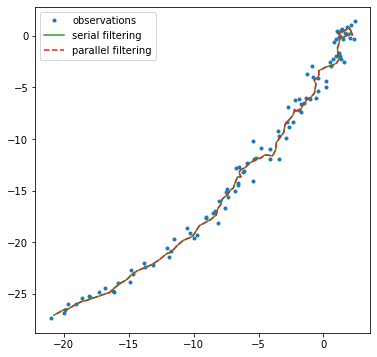

In [11]:
plt.figure(figsize=(6,6))
plt.plot(*emissions.T,'.', label="observations")
plt.plot(*ssm_posterior.filtered_means[:,:2].T, color="C2", label="serial filtering")
plt.plot(*parallel_posterior.filtered_means[:,:2].T, "--", color="C3",label="parallel filtering");
plt.legend();

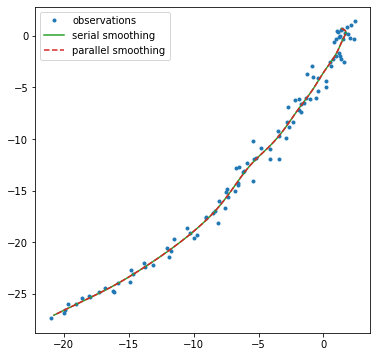

In [12]:
plt.figure(figsize=(6,6))
plt.plot(*emissions.T,'.', label="observations")
plt.plot(*ssm_posterior.smoothed_means[:,:2].T, color="C2", label="serial smoothing")
plt.plot(*parallel_posterior.smoothed_means[:,:2].T, "--", color="C3",label="parallel smoothing")
plt.legend();


## Timing comparison

In [15]:
key = jr.PRNGKey(0)
if cpu_mode:
    Ts = [100, 200, 500]
    num_repeats = 1
else:
    Ts = [100, 1_000, 10_000, 100_000]
    num_repeats = 3
serial_smoothing_durations = []
parallel_smoothing_durations = []
compiled = False

for T in Ts:
    
    key, subkey = jr.split(key)
    z,emissions = lgssm.sample(params, subkey, T)

    if not compiled:
        ssm_posterior = block_until_ready(lgssm_smoother(params, emissions))
        parallel_posterior = block_until_ready(parallel_lgssm_smoother(params, emissions))
    
    start = time.time()
    for _ in range(num_repeats):
        ssm_posterior = block_until_ready(lgssm_smoother(params, emissions))
    end = time.time()
    mean_time = (end-start)/num_repeats
    serial_smoothing_durations.append(mean_time)
    print(f"Num timesteps={T}, \t time serial = {mean_time}")
    
    start = time.time()
    for _ in range(num_repeats):
        parallel_posterior = block_until_ready(parallel_lgssm_smoother(params, emissions))
    end = time.time()
    mean_time = (end-start)/num_repeats
    parallel_smoothing_durations.append(mean_time)
    print(f"Num timesteps={T}, \t time parallel = {mean_time}")

Num timesteps=100, 	 time serial = 0.5520718097686768
Num timesteps=100, 	 time parallel = 0.27495622634887695
Num timesteps=200, 	 time serial = 0.5372998714447021
Num timesteps=200, 	 time parallel = 0.29311299324035645
Num timesteps=500, 	 time serial = 0.5538558959960938
Num timesteps=500, 	 time parallel = 0.34401488304138184


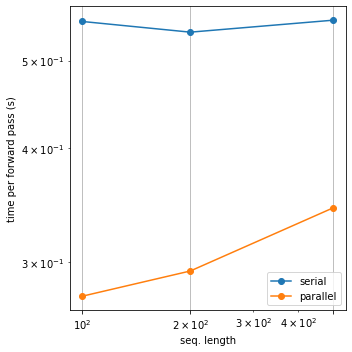

In [16]:
plt.figure(figsize=(5, 5))
plt.loglog(Ts, serial_smoothing_durations, '-o', label='serial')
plt.loglog(Ts, parallel_smoothing_durations, '-o', label='parallel')
plt.xticks(Ts)
plt.xlabel("seq. length")
plt.ylabel("time per forward pass (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()